In [23]:
from models.datasets import MonumentsDataset
from models import datasets
from models.utils import get_train_transform, collate_fn
from models import fasterrcnn
from datasets import class_list
from torch.utils.data import DataLoader

In [24]:
model = fasterrcnn.fasterrcnn_resnet50_fpn(num_classes=17)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Dell/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [27]:
import torch
model_path=r"D:\Major\train\model.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# weights=torch.load(model_path)

<All keys matched successfully>

In [28]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [29]:
clases=['kiranteshwor mahadev', 'charumati', 'kumaristhan', 'ume_maheshwara', 'jaya bageshwori', 'birupakshya', 'Naxal Bhagwati', 'Krishna_temple _kobahal', 'chakku bakku', 'golden temple', 'Ram Mandir', 'uma maheshwor', 'Maitidevi Temple', 'guyeshwori', 'nagarmandap shree kriti bihar', 'Jalbinayak']

In [31]:
TRAIN_DIR = "D:\Major\code\dataset"
dataset = MonumentsDataset(TRAIN_DIR, 512, 512, clases, get_train_transform())

['IMG20230626113905.jpg', 'IMG20230626113906.jpg', 'IMG20230626113907.jpg', 'IMG20230626113908.jpg', 'IMG20230626113912.jpg']


In [32]:
import torch
indices = torch.randperm(len(dataset)).tolist()
print(len(indices))
print(indices[:20])

8654
[576, 6952, 1483, 4141, 7487, 7725, 448, 4811, 1085, 7340, 1600, 1212, 2149, 2950, 8575, 7652, 7428, 6675, 2538, 3676]


In [33]:
train_set = torch.utils.data.Subset(dataset, indices[:-500])
eval_set=torch.utils.data.Subset(dataset, indices[-500:])

In [34]:
valid_loader = DataLoader(
    eval_set,
    batch_size=5,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
    )

In [35]:
original=[]
predicted=[]
imgs=0
with torch.no_grad():
    for batch in valid_loader:
        images, targets = batch
        images = list(image.to('cpu') for image in images)
        imgs+=len(images)
        target = [{k: v.to('cpu') for k, v in t.items()} for t in targets]  
        original.extend(target)
        predictions = model(images)
        predicted.extend(predictions)
print(imgs)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000017CC8E65E40>
Traceback (most recent call last):
  File "D:\anaconda\envs\myenv\Lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "D:\anaconda\envs\myenv\Lib\site-packages\torch\utils\data\dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "D:\anaconda\envs\myenv\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda\envs\myenv\Lib\multiprocessing\popen_spawn_win32.py", line 109, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
print(len(predicted))

In [ ]:
print(len(original))

In [75]:
from torch import tensor
predictions=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],
                     [122.5349, 163.8023, 265.8016, 401.8894],
                     [ 27.4188,  55.2320, 286.0090, 452.0019]]), 
              'labels': tensor([1, 1, 4]),
              'scores': tensor([0.9965, 0.2779, 0.0586])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([12]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676],
                               [106.7353, 121.3933, 373.4354, 412.4706]]),
              'labels': tensor([8, 2]),
              'scores': tensor([0.9917, 0.0847])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447],
                               [146.9601, 165.3507, 469.2495, 417.4515],
                               [ 61.8506,  23.7119, 470.3089, 432.0762],
                               [ 86.0900,  59.0844, 436.2623, 460.5981],
                               [134.8938,  92.4572, 458.3427, 414.5243],
                               [ 36.1431,  89.5182, 480.6086, 381.3042],
                               [140.2368, 103.6454, 453.7489, 434.0392]]),
              'labels': tensor([ 3,  8,  4, 12,  6,  8,  7]),
              'scores': tensor([0.8088, 0.4658, 0.2955, 0.2125, 0.1203, 0.0985, 0.0970])}]


In [76]:
filtered_predictions = []

for pred in predicted:
    scores = pred['scores']
    indices = scores > 0.6
    if indices.any():
        filtered_boxes = pred['boxes'][indices]
        filtered_labels = pred['labels'][indices]
        filtered_scores = pred['scores'][indices]
        filtered_pred = {'boxes': filtered_boxes,
                         'labels': filtered_labels,
                         'scores': filtered_scores}
    else:
        filtered_boxes = torch.tensor([[0, 0, 0, 0]])
        filtered_labels = torch.tensor([0])
        filtered_scores =torch.tensor([0])
        filtered_pred = {'boxes': filtered_boxes,
                         'labels': filtered_labels,
                         'scores': filtered_scores}
    filtered_predictions.append(filtered_pred)
        
true_positives =0
for i, (pred,orig) in enumerate(zip(filtered_predictions,original),1):
    print(f"Prediction {i}:",end='')
    print(f"\t\t\t\t\t\t\tOriginal {i}:")
    print("\tBoxes:",end='')
    print("\t\t\t\t\t\t\tBoxes:")
    print(f"\t{pred['boxes']}",end='')
    print(f"\t{orig['boxes']}")
    print("\tLabels:",end='')
    print("\t\t\t\t\t\t\tLabels:")
    print(f"\t{pred['labels']}",end='')
    
    print(f"\t\t\t\t\t\t{orig['labels']}")
    print("\tScores:")
    print(f"\t{pred['scores']}")
    if(torch.any(pred['labels']==orig['labels'])):
        true_positives+=1
    print()
    
print(f"True Positives={true_positives}")
  
    
    

#     print("\tScores:")
#     print(f"\t{pred['scores']}")
 

Prediction 1:							Original 1:
	Boxes:							Boxes:
	tensor([[ 95.2413, 136.6463, 384.5086, 407.0092]])	tensor([[ 94., 148., 389., 405.]])
	Labels:							Labels:
	tensor([8])						tensor([8])
	Scores:
	tensor([0.9975])

Prediction 2:							Original 2:
	Boxes:							Boxes:
	tensor([[197.0715, 104.7834, 396.1111, 293.7659]])	tensor([[199., 100., 397., 290.]])
	Labels:							Labels:
	tensor([4])						tensor([4])
	Scores:
	tensor([0.9984])

Prediction 3:							Original 3:
	Boxes:							Boxes:
	tensor([[156.0770,  91.6311, 372.2458, 355.5373]])	tensor([[152.,  89., 369., 360.]])
	Labels:							Labels:
	tensor([9])						tensor([9])
	Scores:
	tensor([0.9955])

Prediction 4:							Original 4:
	Boxes:							Boxes:
	tensor([[115.0316, 106.4095, 387.3314, 334.4220]])	tensor([[114., 115., 395., 317.]])
	Labels:							Labels:
	tensor([8])						tensor([8])
	Scores:
	tensor([0.9936])

Prediction 5:							Original 5:
	Boxes:							Boxes:
	tensor([[177.3145, 108.2242, 375.5677, 367.3140]])	tensor([[17

	tensor([[ 95.5957, 120.0086, 399.5831, 422.3223]])	tensor([[113., 127., 399., 389.]])
	Labels:							Labels:
	tensor([12])						tensor([12])
	Scores:
	tensor([0.9991])

Prediction 124:							Original 124:
	Boxes:							Boxes:
	tensor([[  0.0000,   9.3620, 510.7340, 512.0000]])	tensor([[ 21.,   1., 509., 496.]])
	Labels:							Labels:
	tensor([1])						tensor([1])
	Scores:
	tensor([0.9974])

Prediction 125:							Original 125:
	Boxes:							Boxes:
	tensor([[157.2525,  64.9768, 423.2446, 413.0457]])	tensor([[125.,  55., 433., 453.]])
	Labels:							Labels:
	tensor([7])						tensor([7])
	Scores:
	tensor([0.9978])

Prediction 126:							Original 126:
	Boxes:							Boxes:
	tensor([[0, 0, 0, 0]])	tensor([[ 11.,  66., 512., 448.]])
	Labels:							Labels:
	tensor([0])						tensor([11])
	Scores:
	tensor([0])

Prediction 127:							Original 127:
	Boxes:							Boxes:
	tensor([[117.2661,  10.9893, 436.3310, 343.1112]])	tensor([[113.,   9., 407., 367.]])
	Labels:							Labels:
	tensor([13])						t


Prediction 228:							Original 228:
	Boxes:							Boxes:
	tensor([[ 46.9651,  51.4191, 475.4034, 403.2970]])	tensor([[ 84.,  65., 465., 358.]])
	Labels:							Labels:
	tensor([4])						tensor([15])
	Scores:
	tensor([0.7225])

Prediction 229:							Original 229:
	Boxes:							Boxes:
	tensor([[ 87.9727, 179.5612, 422.5520, 493.2216]])	tensor([[ 89., 180., 434., 484.]])
	Labels:							Labels:
	tensor([8])						tensor([8])
	Scores:
	tensor([0.9984])

Prediction 230:							Original 230:
	Boxes:							Boxes:
	tensor([[  8.4622, 121.0364, 347.6266, 338.9372]])	tensor([[ 14., 128., 364., 324.]])
	Labels:							Labels:
	tensor([8])						tensor([8])
	Scores:
	tensor([0.9982])

Prediction 231:							Original 231:
	Boxes:							Boxes:
	tensor([[ 51.6915,  91.0810, 378.3530, 461.5988]])	tensor([[  1.,  63., 448., 442.]])
	Labels:							Labels:
	tensor([3])						tensor([11])
	Scores:
	tensor([0.6458])

Prediction 232:							Original 232:
	Boxes:							Boxes:
	tensor([[ 69.7592, 131.1652, 374.1430, 

	tensor([[ 63.2554,  63.0863, 398.7437, 466.4203]])	tensor([[ 75.,  70., 417., 488.]])
	Labels:							Labels:
	tensor([9])						tensor([9])
	Scores:
	tensor([0.9965])

Prediction 321:							Original 321:
	Boxes:							Boxes:
	tensor([[186.9858,  88.8832, 397.3238, 281.3643]])	tensor([[191.,  78., 398., 271.]])
	Labels:							Labels:
	tensor([4])						tensor([4])
	Scores:
	tensor([0.9987])

Prediction 322:							Original 322:
	Boxes:							Boxes:
	tensor([[138.3019, 136.2017, 300.7197, 300.5942]])	tensor([[147., 136., 301., 292.]])
	Labels:							Labels:
	tensor([6])						tensor([6])
	Scores:
	tensor([0.9944])

Prediction 323:							Original 323:
	Boxes:							Boxes:
	tensor([[0, 0, 0, 0]])	tensor([[140., 161., 399., 327.]])
	Labels:							Labels:
	tensor([0])						tensor([0])
	Scores:
	tensor([0])

Prediction 324:							Original 324:
	Boxes:							Boxes:
	tensor([[199.8888, 180.6686, 285.1886, 383.8097]])	tensor([[198., 180., 287., 386.]])
	Labels:							Labels:
	tensor([5])						tenso

	tensor([0])

Prediction 472:							Original 472:
	Boxes:							Boxes:
	tensor([[ 89.0613,  60.6071, 424.2079, 453.4237]])	tensor([[ 58.,  77., 418., 440.]])
	Labels:							Labels:
	tensor([1])						tensor([1])
	Scores:
	tensor([0.9991])

Prediction 473:							Original 473:
	Boxes:							Boxes:
	tensor([[120.8796,  67.5337, 398.6066, 382.5047]])	tensor([[120.,  73., 397., 386.]])
	Labels:							Labels:
	tensor([4])						tensor([4])
	Scores:
	tensor([0.9976])

Prediction 474:							Original 474:
	Boxes:							Boxes:
	tensor([[176.2030,  94.6946, 447.2845, 389.8564]])	tensor([[206., 108., 445., 368.]])
	Labels:							Labels:
	tensor([8])						tensor([8])
	Scores:
	tensor([0.9977])

Prediction 475:							Original 475:
	Boxes:							Boxes:
	tensor([[ 98.1250, 218.4668, 193.1157, 370.3509]])	tensor([[ 94., 219., 190., 372.]])
	Labels:							Labels:
	tensor([5])						tensor([5])
	Scores:
	tensor([0.9985])

Prediction 476:							Original 476:
	Boxes:							Boxes:
	tensor([[ 87.2966, 126.2361,

In [77]:
len(filtered_predictions)

500

In [3]:
from torch import tensor
predictions=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],
                     [122.5349, 163.8023, 265.8016, 401.8894],
                     [ 27.4188,  55.2320, 286.0090, 452.0019]]), 
              'labels': tensor([1, 1, 4]),
              'scores': tensor([0.9965, 0.2779, 0.0586])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([12]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676],
                               [106.7353, 121.3933, 373.4354, 412.4706]]),
              'labels': tensor([8, 2]),
              'scores': tensor([0.9917, 0.0847])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447],
                               [146.9601, 165.3507, 469.2495, 417.4515],
                               [ 61.8506,  23.7119, 470.3089, 432.0762],
                               [ 86.0900,  59.0844, 436.2623, 460.5981],
                               [134.8938,  92.4572, 458.3427, 414.5243],
                               [ 36.1431,  89.5182, 480.6086, 381.3042],
                               [140.2368, 103.6454, 453.7489, 434.0392]]),
              'labels': tensor([ 3,  8,  4, 12,  6,  8,  7]),
              'scores': tensor([0.8088, 0.4658, 0.2955, 0.2125, 0.1203, 0.0985, 0.0970])}]

targets=[{'boxes': tensor([[ 84.1036,  76.5165, 271.7503, 443.8830],
                    ]), 
              'labels': tensor([1, ]),
              'scores': tensor([0.9965])},
             {'boxes': tensor([[239.2319, 219.7705, 343.4445, 404.7963]]),
              'labels': tensor([5]),
              'scores': tensor([0.9982])},
             {'boxes': tensor([[ 77.5203,  86.0100, 506.1534, 484.8054]]),
              'labels': tensor([12]),
              'scores': tensor([0.9954])},
             {'boxes': tensor([[134.1839, 174.5545, 394.9434, 375.4676]]),
              'labels': tensor([8]),
              'scores': tensor([0.9917])},
             {'boxes': tensor([[106.1037,  84.3046, 465.6261, 400.9447]
                              ]),
              'labels': tensor([3]),
              'scores': tensor([0.8088])}]

In [10]:
filtered_predictions = []
for pred in predictions:
    scores = pred['scores']
    indices = scores > 0.6
    if indices.any():
        filtered_boxes = pred['boxes'][indices]
        filtered_labels = pred['labels'][indices]
        filtered_scores = pred['scores'][indices]
        filtered_pred = {'boxes': filtered_boxes,
                         'labels': filtered_labels,
                         'scores': filtered_scores}
    else:
        filtered_boxes = torch.tensor([[0, 0, 0, 0]])
        filtered_labels = torch.tensor([0])
        filtered_scores =torch.tensor([0])
        filtered_pred = {'boxes': filtered_boxes,
                         'labels': filtered_labels,
                         'scores': filtered_scores}

    filtered_predictions.append(filtered_pred)

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
pred_labels = np.concatenate([pred['labels'].cpu().numpy() for pred in filtered_predictions])
pred_scores = np.concatenate([pred['scores'].cpu().numpy() for pred in filtered_predictions])
target_labels = np.concatenate([target['labels'].cpu().numpy() for target in targets])
# Threshold the predictions based on scores (keeping only those with scores > 0.6)
threshold = 0.6
# filtered_indices = np.where(pred_scores > threshold)[0]
# pred_labels = pred_labels[filtered_indices]
# Create the confusion matrix
conf_matrix = confusion_matrix(np.sort(target_labels), np.sort(pred_labels))
print("Confusion Matrix:")
print(conf_matrix)
print(np.sort(target_labels),np.sort(pred_labels))
print(type(target_labels),pred_labels.sort())


Confusion Matrix:
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
[ 1  3  5  8 12] [ 1  3  5  8 12]
<class 'numpy.ndarray'> None


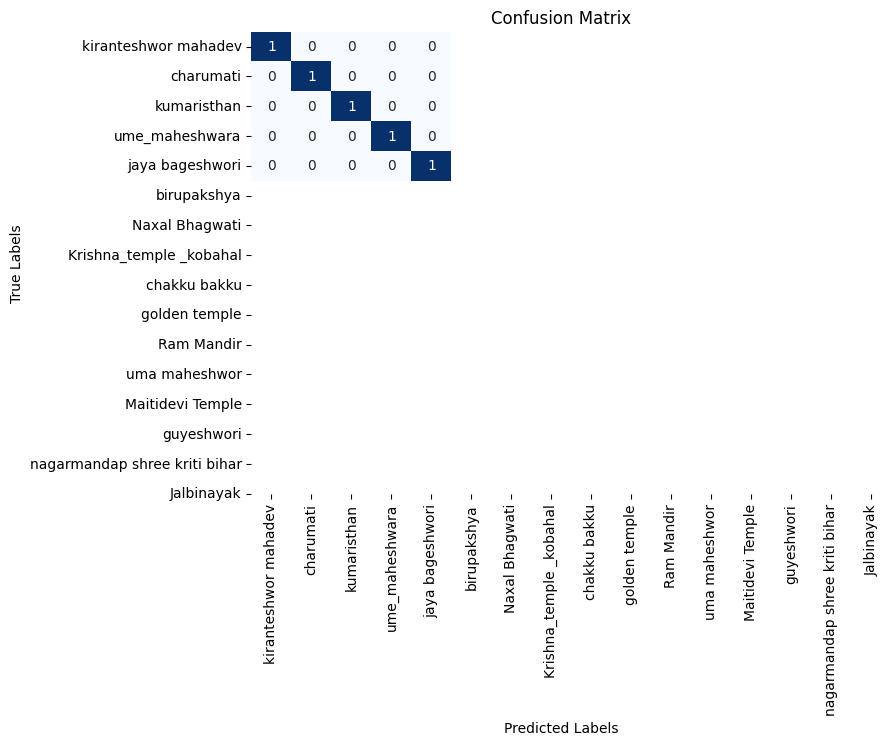

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()